### this is the notebook where im making the model, testing out input shapes, plotting stuff. 
## the training python file does the training, but ill have the code here too


In [39]:
import torch
import torchvision
import os
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.functional as F
import matplotlib.pyplot as plt

# Download MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


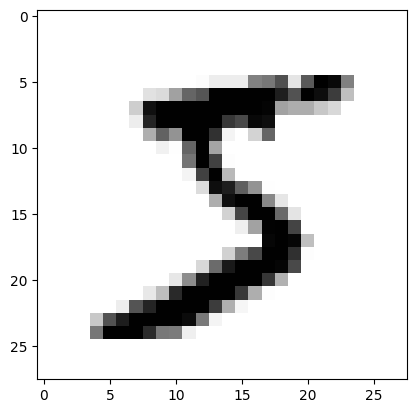

In [40]:
plt.imshow(train_dataset[0][0][0],cmap="binary")
plt.show()

### forward process
![forward process](https://miro.medium.com/v2/resize:fit:640/format:webp/0*WK3wnFRWC2GIcH1r.png)

In [41]:
#DDPM
# the constant Beta tells us how much noise is added at each timestamp
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

#improved DDPM paper used cosine schedule it seems
def cosine_schedule(num_timesteps, s=0.008):
  def f(t):
    return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
  x = torch.linspace(0, num_timesteps, num_timesteps + 1)
  alphas_cumprod = f(x) / f(torch.tensor([0]))
  betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
  betas = torch.clip(betas, 0.0001, 0.999)
  return betas

def sample_by_t(tensor_to_sample, timesteps, x_shape):
  batch_size = timesteps.shape[0]
  sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
  sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
  return sampled_tensor.to(timesteps.device)

num_timesteps = 1000
betas_t = linear_schedule(num_timesteps)

alphas_t = 1-betas_t
# sqrt_alphas_t = torch.sqrt(alphas_t)
# oneminus_alphas_t = 1 - alphas_t
# sqrt_oneminus_alphas_t = torch.sqrt(oneminus_alphas_t)
# one_over_sqrt_aplhas_t = 1. / sqrt_alphas_t

alphas_bar_t = torch.cumprod(alphas_t,dim=0)
alphas_bar_t_minus_1 = torch.cat((torch.tensor([0]),alphas_bar_t[:-1]))

sqrt_alphas_bar_t = torch.sqrt(alphas_bar_t)
sqrt_1_minus_alphas_bar_t = torch.sqrt(1. - alphas_bar_t)



### POSTERIOR VARIANCE ###
""" 
in simple terms posterior variance is the variance of reverse process in ddpm pamer -> (q(xₜ₋₁ | xₜ, x₀))
its needed for reverse process to sample correctly

betas_t control noise at each timestep
alphas_t is from betas_t

alphas bar t aka cumilative product of all alphas represents total noise upto each step

sqrt stuff is used for the calculations in the formula

alphas_bar_t_minus_1 is same as alphas_bar_t  it just has one 0 appended at the start of it ,
for the first timestamp

( \alpha_{\bar{t}} ) is the cumulative product of ( \alpha_t ) up to timestep ( t ).
( \alpha_{\bar{t-1}} ) is the cumulative product up to timestep ( t-1 ).
( \beta_t ) is the noise added at timestep ( t ).

the formula
[ \text{posterior variance} = \frac{1 - \alpha_{\bar{t-1}}}{1 - \alpha_{\bar{t}}} \cdot \beta_t ]

Meaning:
It gives the conditional variance for the reverse process (going from ( x_t ) to ( x_{t-1} )),
ensuring the reverse step is properly calibrated according to how much noise has been added so far.
This is derived from the DDPM paper and is crucial for correct sampling in the denoising process.
"""
posterior_variance = (1. -alphas_bar_t_minus_1) / (1. - alphas_bar_t) * betas_t

#the equation is  Xt = sqrt(at)Xo + sqrt(1-at)E
# ***E is the noise***,
# and at, 1-at decide how much noise gets added each step
# we have a constant before Xo too , so that the mean
# does not stay at Xo and its a normal distribution

# forward sampling process

def sample_q(x0,t,noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
        
    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t,t,x0.shape)
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t,t,x0.shape)
    
    x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
    return x_t



<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:43: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_36788\1412501301.py:43: SyntaxWarning: invalid escape sequence '\c'
  """


In [42]:
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize, Normalize

image_size = 28
transform = Compose([
  Resize(image_size),  # resize smaller edge to image_size
  CenterCrop(image_size),  # make a square image with size image_size
  ToTensor(),  # convert to tensor with shape CHW and values in the range [0, 1]
  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # set the values to the range [-1, 1]
])

In [43]:
from torchvision.transforms import ToPILImage

reverse_transform_pil = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
  ToPILImage()
])

reverse_transform_tensor = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
])

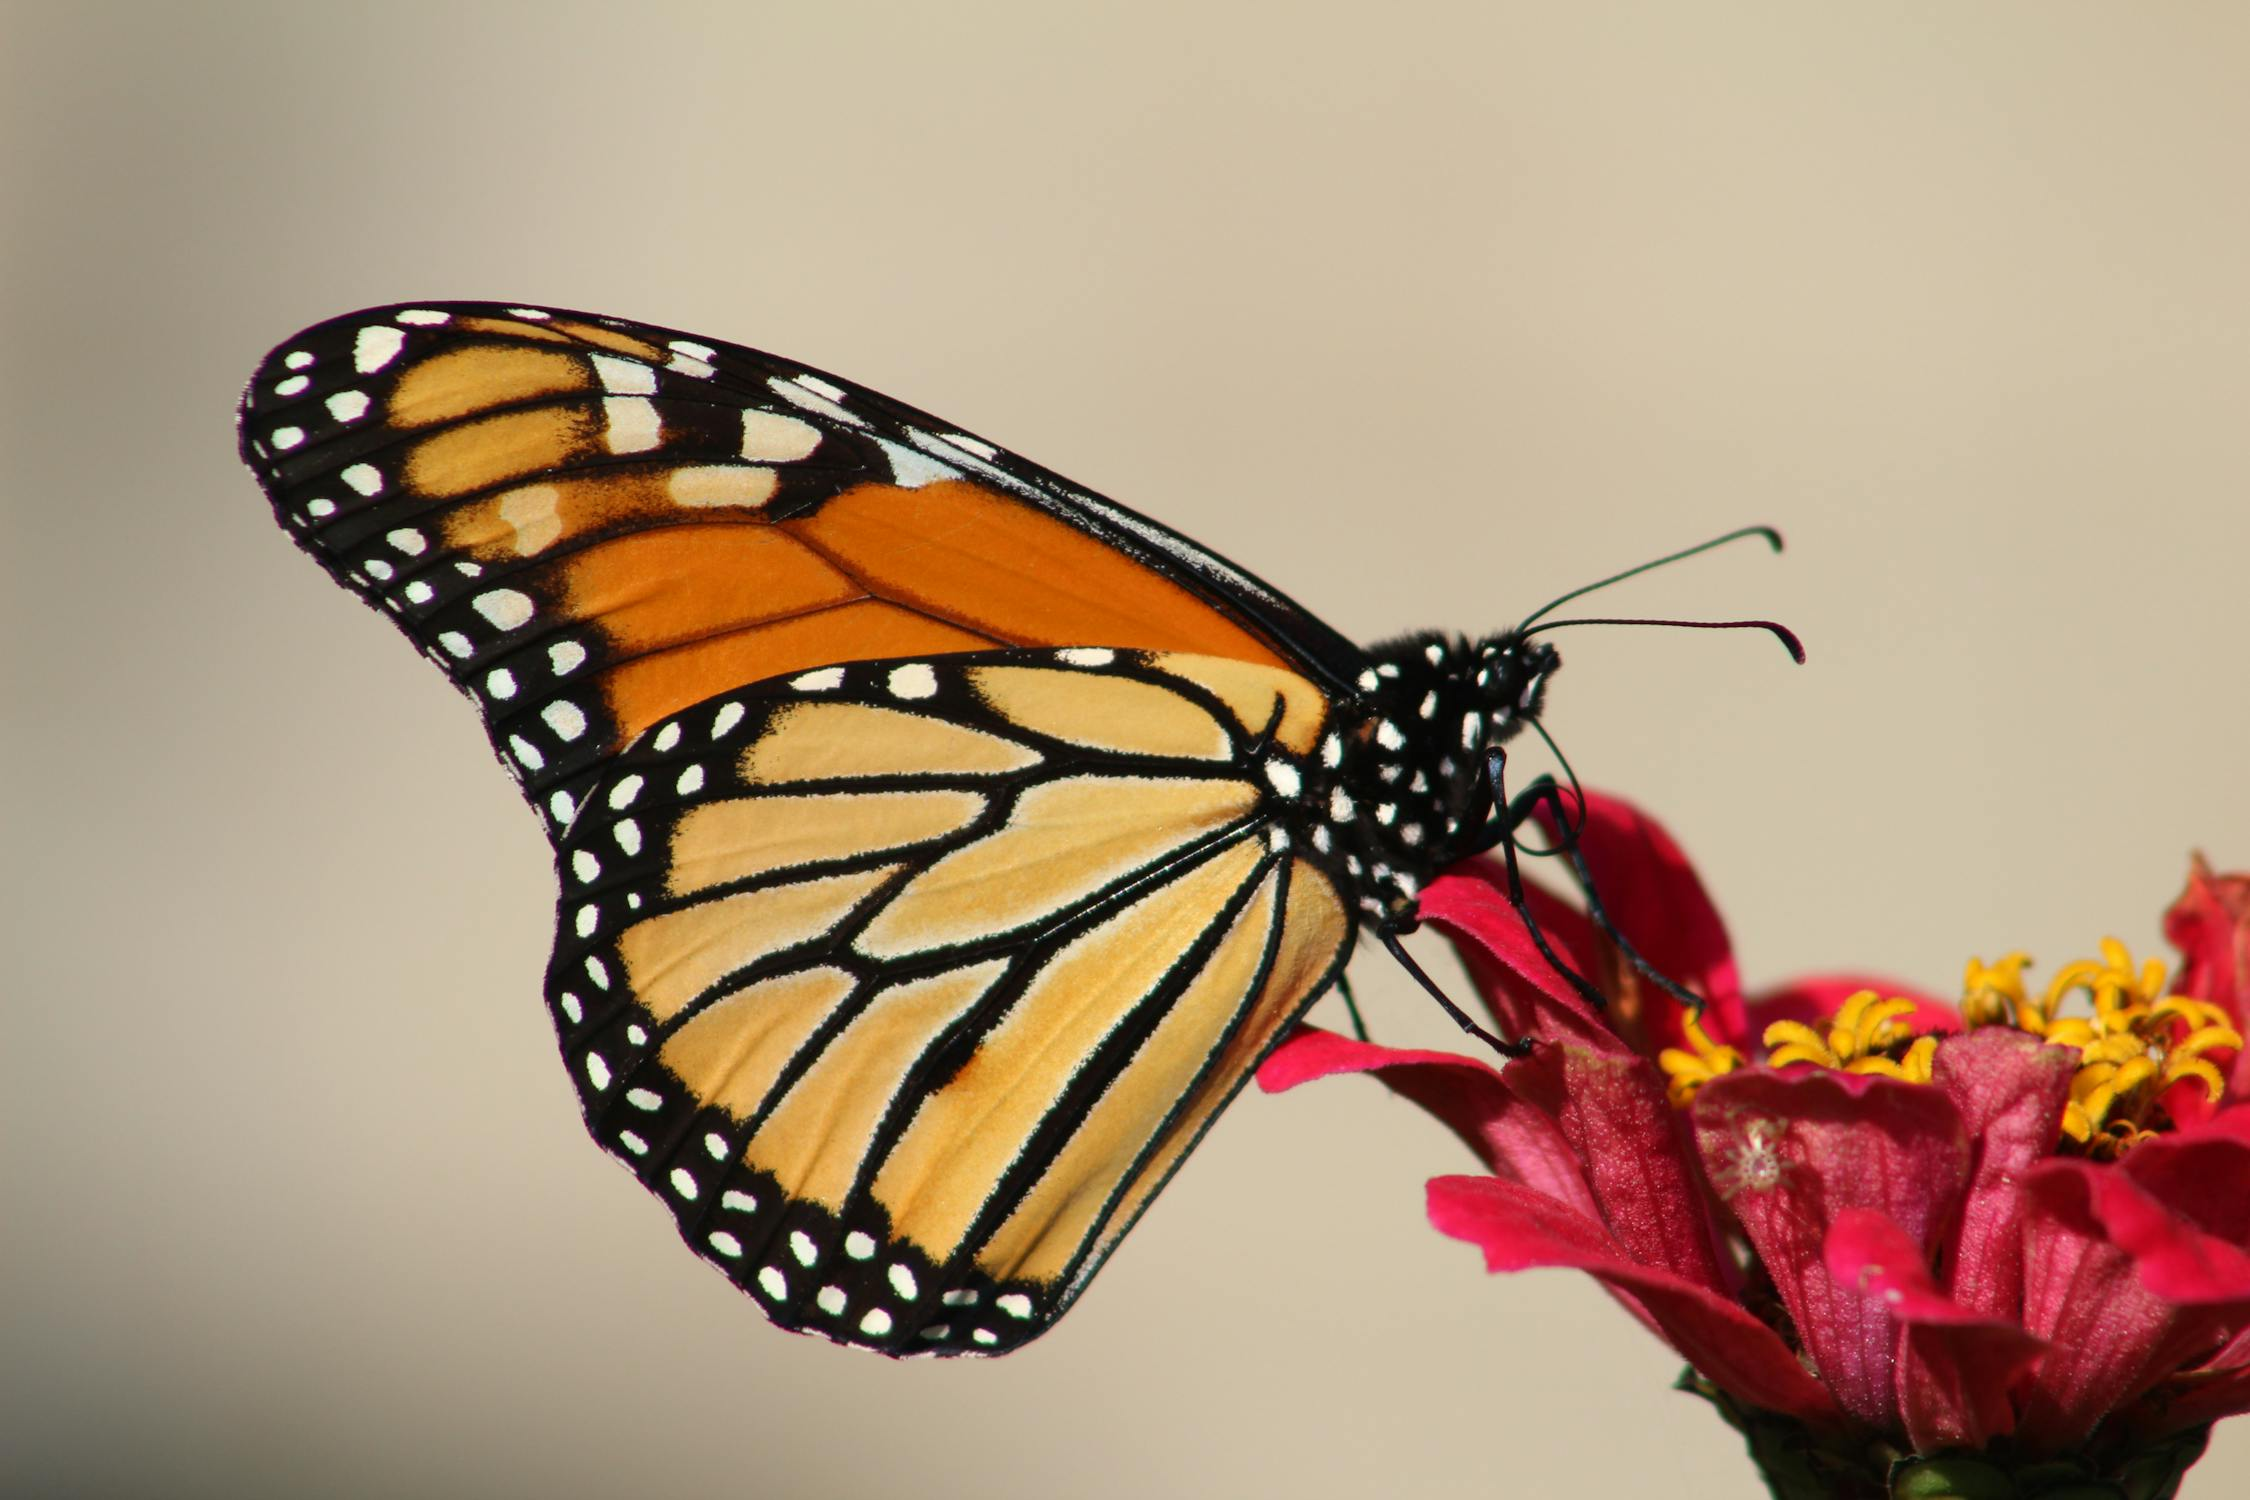

In [44]:
import requests
from PIL import Image

url = 'https://images.pexels.com/photos/1557208/pexels-photo-1557208.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2'
image_raw_data = requests.get(url, stream=True).raw
image = Image.open(image_raw_data)
image

In [45]:
def get_noisy_image(x0, t, transform=reverse_transform_pil):
  x_noisy = sample_q(x0, t)
  noise_image = transform(x_noisy.squeeze())
  return noise_image

import matplotlib.pyplot as plt
def show_noisy_images(noisy_images):
    """
    Show and return a grid of noisy images where
    the rows are different images, and the columns
    are the noisy images in different timesteps.

    Args:
    noisy_images (list[list[PIL]]): a list with a lists of images
        with noise from different timesteps.
    """
    num_of_image_sets = len(noisy_images)
    num_of_images_in_set = len(noisy_images[0])
    image_size = noisy_images[0][0].size[0]

    full_image = Image.new('RGB', (image_size * num_of_images_in_set + (num_of_images_in_set - 1), image_size * num_of_image_sets + (num_of_image_sets - 1)))
    for set_index, image_set in enumerate(noisy_images):
        for image_index, image in enumerate(image_set):
            full_image.paste(image, (image_index * image_size + image_index, set_index * image_size + set_index))
    
    
    plt.imshow(full_image)
    plt.axis('off')
    return full_image

In [46]:
x0 = transform(image).unsqueeze(0)  # Add batch dimension

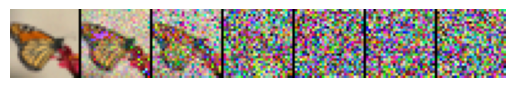

In [47]:
show_noisy_images([[get_noisy_image(x0,torch.tensor([t])) for t in [0,50,100,200,500,700,999]]])

In [49]:
def space_to_depth(x, size=2):
    """
    Downsacle method that use the depth dimension to
    downscale the spatial dimensions
    Args:
        x (torch.Tensor): a tensor to downscale
        size (float): the scaling factor

    Returns:
        (torch.Tensor): new spatial downscale tensor
    """
    
    b,c,h,w = x.shape()
    
    out_h = h
    out_w = w
    out_c = c * (size*size)
    
    x = x.reshape((-1,c,out_h,size,out_w,size))
    x = x.permute((0,1,3,5,2,4))
    x = x.reshape((-1,out_c,out_h,out_w))
    
    return x


class SpaceToDepth(nn.Module):
    
    def __init__(self,size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.size = size
        
    def forward(self,x):
        return space_to_depth(x,self.size)
    
class Residual(nn.Module):
    """
    Apply residual connection using an input function
    Args:
    func (function): a function to apply over the input
    """
    def __init__(self,func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.func = func
        
    def forward(self,x,*args,**kwargs):
        return x.self.func(x,*args,**kwargs)
    
def upsample(in_channels,out_channels=None):
    out_channels = in_channels if out_channels is None else out_channels
    seq = nn.Sequential(
        nn.Upsample(scale_factor=2,mode="nearest"),
        nn.conv2d(in_channels,out_channels,3,padding=1)
    )
    return seq

def downsample(in_channels,out_channels=None):
    out_channels = in_channels if out_channels is None else out_channels
    seq = nn.Sequential(
        SpaceToDepth(2),
        nn.Conv2d(4*in_channels, out_channels,1)
    )
    return seq

class SinusodialPositionEmbedding(nn.Module):
  def __init__(self, embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim

  def forward(self, time_steps):
    positions = torch.unsqueeze(time_steps, 1)
    half_dim = self.embedding_dim // 2
    embeddings = torch.zeros((time_steps.shape[0], self.embedding_dim), device=time_steps.device)
    denominators = 10_000 ** (2 * torch.arange(self.embedding_dim // 2, device=time_steps.device) / self.embedding_dim)
    embeddings[:, 0::2] = torch.sin(positions/denominators)
    embeddings[:, 1::2] = torch.cos(positions/denominators)
    return embeddings

class WeightStandardizedConv2d(nn.Conv2d):
  """
  https://arxiv.org/abs/1903.10520
  """

  def forward(self, x):
    eps = 1e-5 if x.dtype == torch.float32 else 1e-3

    weight = self.weight
    mean = weight.mean(dim=[1,2,3], keepdim=True)
    variance = weight.var(dim=[1,2,3], keepdim=True, correction=0)
    normalized_weight = (weight - mean) / torch.sqrt(variance)

    return F.conv2d(
        x,
        normalized_weight,
        self.bias,
        self.stride,
        self.padding,
        self.dilation,
        self.groups
    )


In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels,out_channels,groups=8):
        self.proj = WeightStandardizedConv2d(in_channels,out_channels,3,padding=1)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.act = nn.SiLU()
        
    def forward(self, x,scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        
        if scale_shift is not None:
            scale,shift = scale_shift
            x = x * (scale + 1) + shift
            
        x = self.act(x)
        return x
    
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim=None, groups=8):
        super().__init__()
        
        if time_embed_dim is not None:
            self.mlp = nn.Sequential(
                nn.SiLU,
                nn.Linear(time_embed_dim,2*out_channels)
            )
        else:
            self.mlp = None
            
        self.block1 = Block(in_channels,out_channels,groups)
        self.block2 = Block(out_channels,out_channels,groups)
        
        if in_channels == out_channels:
            self.res_conv = nn.Identity()
        else:
            self.res_conv = nn.conv2d(in_channels,out_channels,1)
            
    def forward(self, x, time_embedding=None):
        scale_shift = None
        if self.mlp is not None and time_embedding is not None:
            time_emb = self.mlp(time_embedding)
            time_emb = time_emb.view(*time_emb.shape,1,1)
            scale_shift = time_emb.chunk(2,dim=1)
            
        h = self.block1(x,scale_shift=scale_shift)
        h = self.block2(h)
        
        return h + self.res_conv(x)
    
    
class Attention(nn.Module):
    def __init__(self,in_channels,out_channels,num_heads=4,dim_head=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        